# rAdvisor Results

## Synthetic Benchmark

Benchmark used to generate system monitor logs that is designed to stress a variety of system resources, such as network, cpu, memory, and I/O

> Note: Outputs nano timestamps each command, preceded by `__N\n` where N is an incrementing hex digit

In [45]:
import parser

files = parser.get_all_files("./logs/v1.1.0/kubernetes", "log")
data = parser.parse_all(files)

Parsing log data from logs/v1.1.0/kubernetes/82f12ba1-4b82-417d-8764-dcf6f01510ea_1585470948.log... done
Parsing log data from logs/v1.1.0/kubernetes/a9b8ab1a-0b03-436f-861d-8ebf55b33129_1585470948.log... done
Parsing log data from logs/v1.1.0/kubernetes/e9c94167-614c-4dbd-879c-e3abeacef198_1585470948.log... done
Parsing log data from logs/v1.1.0/kubernetes/9f0b1893-15e7-442a-966a-b0d19a35fc1c_1585470948.log... done
Parsing log data from logs/v1.1.0/kubernetes/ff979cd5-dfba-4b15-84a0-c2aac5d1d5a1_1585470948.log... done


In [66]:
target_file = './logs/v1.1.0/kubernetes/9f0b1893-15e7-442a-966a-b0d19a35fc1c_1585470948.log'
entries = data[target_file]

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

all_deltas = [d for f in data.keys() for d in parser.get_ts_deltas(data[f])]
all_deltas_df = pd.DataFrame({'Read deltas (ms)': all_deltas})
print(all_deltas_df.describe(include='all'))    

min_ts = min(e.read for e in entries.values())

def to_s(nano_ts):
    return float(nano_ts - min_ts) / 1E9

       Read deltas (ms)
count      75015.000000
mean          52.009075
std            0.126684
min           51.916260
25%           51.985352
50%           51.993164
75%           52.004883
max           58.537109


## Overall PIT Graphs

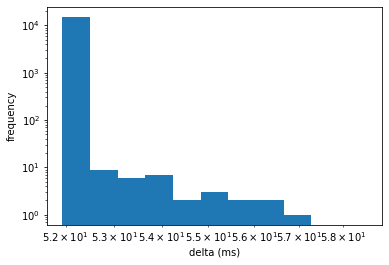

In [67]:
deltas = parser.get_ts_deltas(entries)
# deltas = all_deltas
deltas_series = pd.Series(deltas)
plt.hist(deltas, bins=np.geomspace(deltas_series.min(), deltas_series.max(), 12))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("delta (ms)")
plt.ylabel("frequency")
plt.show()

## Timestamp Deltas

The first plot is a histogram, where a logarithmic scale used on both x and y axes. Almost all deltas are closely clustered around 50ms, with a small amount of outliers.

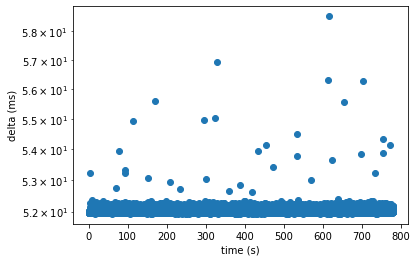

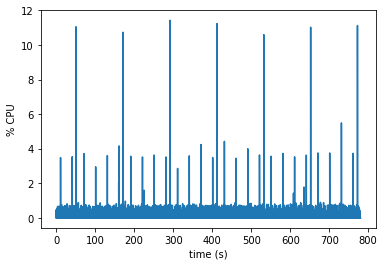

In [68]:
def cpu_per(entry):
    cpu_time = float(entry.cpu.total - entry.pre.cpu.total)
    interval = float(entry.read - entry.pre.read)
    return (cpu_time / interval) * 100

def plot_deltas(reads, deltas):
    tail = reads[1:]
    x_series = [to_s(r) for r in tail]
    y_series = deltas
    
    plt.scatter(x_series, y_series, marker='o')
    plt.yscale('log')
    plt.ylabel("delta (ms)")
    plt.xlabel("time (s)")
    plt.show()

def plot_cpu(entries):
    tail = entries[1:]
    x_series = [to_s(e.read) for e in tail]
    y_series = [cpu_per(e) for e in tail]

    plt.plot(x_series, y_series)
    plt.ylabel("% CPU")
    plt.xlabel("time (s)")
    plt.show()

    
plot_deltas([e.read for e in entries.values()], deltas)
plot_cpu(list(entries.values()))


## Period of High Load


duration of window: 1.92s
lagging % of time: 0.00%



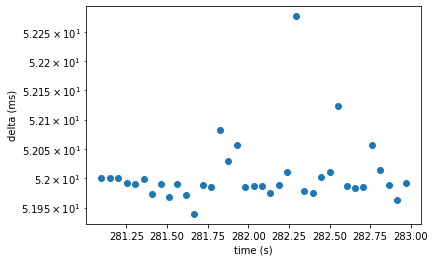

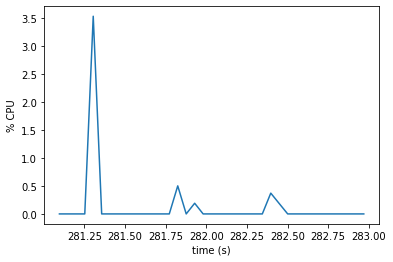

In [72]:
start_s = 281
end_s = 283

ts_list = list(entries.keys())
start = ts_list.index(list(filter(lambda i: to_s(i) > start_s, ts_list))[0])
end = ts_list.index(list(filter(lambda i: to_s(i) > end_s, ts_list))[0])

entries_window = list(entries.values())[start:end]
window = deltas[start:end]

duration = entries_window[-1].read - entries_window[0].read
print()
print("duration of window: {:.2f}s".format(float(duration) / 1E9))

above_60 = np.sum([d for d in window if d > 60])
total = np.sum(window)
lag_proportion = (above_60 / total) * 100
print("lagging % of time: {:.2f}%".format(lag_proportion))
print()

plot_deltas([e.read for e in entries_window], window[:-1])
plot_cpu(entries_window)